In [46]:
# !pip install numpy
# !pip install matplotlib
# Basic setup: imports and define helper functions
import asyncio, asyncssh, sys, time
import numpy as np
import matplotlib.pyplot as plt

ssh_connections = {}
%store -r

async def start_connection(hostname):
    if hostname not in ssh_connections:
        ssh_connections[hostname] = await asyncssh.connect(hostname, known_hosts=None)
    return ssh_connections[hostname]

async def run_command(hostname, command):
    conn = await start_connection(hostname)
    return (await conn.create_process(command))

async def run_command_sync(hostname, command):
    conn = await start_connection(hostname)
    result = await conn.run(command)
    return result.stdout

async def run_server(hostname):
    return (await run_command(hostname, '/mydata/localuser/frida/server/server'))

async def run_client_throughput(hostname, device_id, duration = 10, keepout = 1, datasize = 32, server="http://node0:8080", asyncOn = True):
    command_str = '/mydata/localuser/frida/experiments/throughput_bench/client {} {} {} {} {}'.format(device_id, duration,keepout,datasize,server)
    if asyncOn:
        return (await run_command(hostname, command_str))
    else:
        return (await run_command_sync(hostname, command_str))
async def run_multiple_clients_throughput(num_clients, hostname, device_id_prefix, duration = 10, keepout = 1, datasize = 32, server="http://node0:8080", asyncOn = True):
    command_str = 'cd /mydata/localuser/frida/experiments/throughput_bench && bash ./run_clients_local.sh {} {} {} {} {} {}'.format(num_clients, device_id_prefix, duration,keepout,datasize,server)
    if asyncOn:
        return (await run_command(hostname, command_str))
    else:
        return (await run_command_sync(hostname, command_str))
async def clear_server_storage(hostname):
    await run_command_sync(hostname, "rm -r ~/storage")

async def kill_server(hostname):
    await run_command_sync(hostname, "pkill server")
    
def parse_throughput(tstr):
    return float(tstr.split(",")[1])


In [24]:
cstr= 'cd /mydata/localuser/frida/experiments/throughput_bench && bash ./run_clients_local.sh {} {} {} {} {} http://node0:8080'.format(100, "LEO", 20,5,32)
await run_command("node2", cstr)

In [33]:
for i in range(1,2):
    await run_multiple_clients(200, "node{}".format(2), "LEO", duration = 30, keepout = 10, datasize=32)

In [20]:
# Run server for 10 seconds and then quit it, as a demo
server_task = await run_server("node0")
# time.sleep(10)
# server_task.terminate()

In [26]:
server_task = await run_server("node0")
client_task = await run_client("node1", "abcd")
# print(await client_task.stdout.read()) # TODO this blocks indefinitely
# time.sleep(15)
client_task.terminate()
server_task.terminate()
await run_command("node0", "rm -r ~/storage")

In [34]:
# Kill everything
for i in range(1, num_nodes + 1):
    await run_command("node{}".format(i), "pkill client")
await kill_server("node0")

In [55]:
async def run_throughput_exp(num_nodes = 2, duration = 20, keepout = 5, data_size = 0, min_cpn = 20, max_cpn = 100, step_size = 5, warmup_period = 5, server_node = "node0"):
    max_clients = max_num_clients_per_node * num_nodes
    throughputs = [0]
    num_clients_record = [0]
    
    await kill_server(server_node)
    await clear_server_storage(server_node)
    server_task = await run_server(server_node)

    for num_clients_per_node in range(min_cpn, max_cpn + 1, step_size):
        time.sleep(warmup_period)
        ctasks = []
        num_clients = num_nodes * num_clients_per_node
        for node in range(1, num_nodes + 1):
            ctask = await run_multiple_clients_throughput(num_clients_per_node, "node{}".format(node), "exp_C{}_node{}".format(num_clients, node), duration, keepout, data_size, "http://node0:8080")
            ctasks.append(ctask)
        local_throughputs = []
        time.sleep(duration + warmup_period)
        for ctask in ctasks:
            coutput = await ctask.stdout.read()
            for line in coutput.split("\n")[:-1]:
                if line != "":
                    local_throughputs.append(parse_throughput(line))
            ctask.terminate()
        num_clients_record.append(num_clients)

        throughput = sum(local_throughputs)
        print("#Nodes={}, #Clients={}, Throughput = {}/s".format(num_nodes, num_clients, throughput))
        throughputs.append(throughput)

    server_task.terminate()
    await clear_server_storage(server_node)
    return num_clients_record, throughputs

# %store throughputs
# %store num_nodes
# %store keepout
# %store data_size
# %store num_clients_record
# %store max_num_clients_per_node

In [51]:
num_clients_n1, throughputs_n1 = await run_throughput_exp(num_nodes = 1, min_cpn = 8, max_cpn = 200, step_size=8)
%store num_clients_n1
%store throughputs_n1

num_clients_n2, throughputs_n2 = await run_throughput_exp(num_nodes = 2, min_cpn = 4, max_cpn = 100, step_size=4)
%store num_clients_n2
%store throughputs_n2

num_clients_n4, throughputs_n4 = await run_throughput_exp(num_nodes = 4, min_cpn = 2, max_cpn = 50, step_size=2)
%store num_clients_n4
%store throughputs_n4

num_clients_n8, throughputs_n8 = await run_throughput_exp(num_nodes = 8, min_cpn = 1, max_cpn = 25, step_size=1)
%store num_clients_n8
%store throughputs_n8

#Nodes=2, #Clients=20, Throughput = 1590.4999999999995/s
#Nodes=2, #Clients=40, Throughput = 3506.800000000002/s
#Nodes=2, #Clients=60, Throughput = 11197.299999999997/s
#Nodes=2, #Clients=80, Throughput = 14282.900000000003/s
#Nodes=2, #Clients=100, Throughput = 16333.300000000001/s
#Nodes=2, #Clients=120, Throughput = 17425.5/s
#Nodes=2, #Clients=140, Throughput = 17590.8/s
#Nodes=2, #Clients=160, Throughput = 18616.799999999996/s
#Nodes=2, #Clients=180, Throughput = 18536.6/s
#Nodes=2, #Clients=200, Throughput = 18171.300000000007/s


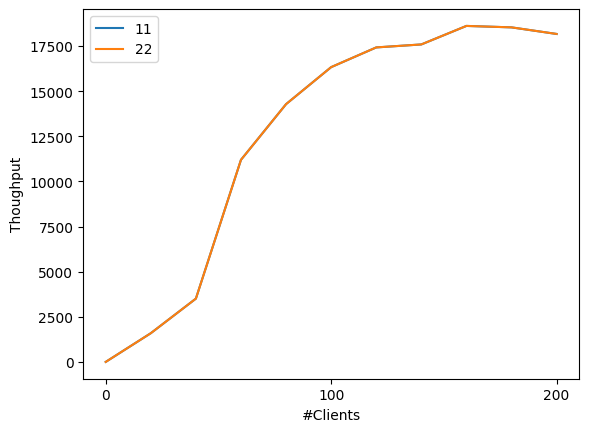

In [60]:
plt.plot(num_clients, throughputs, label="11")
plt.plot(num_clients, throughputs, label="22")
plt.xticks(np.arange(0,max_clients + 1, step = step_size * num_nodes * 5))
plt.xlabel("#Clients")
plt.ylabel("Thoughput")
plt.legend()
plt.show()

In [28]:
await clear_server_storage("node0")
await kill_server("node0")